In [1]:
from functions import *
import pandas as pd
from pathlib import Path

**Read in the data for table generation**

In [5]:
secretion = pd.read_csv('E:\\blastp_hits\\dl_endo_signalp.txt', sep='\t')

dl_map = pd.read_csv('../../data/clustering/cluster_maps/dl_endopeptidase.tsv', sep='\t')

taxonomy = pd.read_csv('E:\\blastp_hits\\taxonomy_mapping.tsv', sep='\t')

uniref_genome = pd.read_csv('E:\\blastp_hits\\uniref_genome_map.txt', sep='\t', header=None, names=['Genome', 'Uniref'])

interpro = pd.read_csv('E:\\blastp_hits\\all_dl_ips.tsv', sep='\t', header=None)

# print(interpro.head(), interpro.shape)
# print(secretion.head(), secretion.shape)
# print(dl_map.head(), dl_map.shape)
# print(taxonomy.head(), taxonomy.shape)
# print(uniref_genome.head(), uniref_genome.shape)

In [ ]:
# Clean the secretion file to include genome IDs and predicitons

secretion['# ID'] = secretion['# ID'].str.split('#').str[0].str.strip()

secretion['Genome'] = secretion['# ID'].str.split('_').str[0]

secretion = secretion[['# ID', 'Genome', 'Prediction']]

secretion['Genome'] = secretion['Genome'].str.strip('.fa')

# secretion = secretion.rename(columns={'# ID': 'Genome'})

# IDs have extra indicators like this: MGYG000155050_27_22 not found in the mapping file. strip themn off for now 

display(secretion.head()) 

In [7]:
# Clean the uniref map add names to columns

uniref_genome.rename(columns={'Genome': '# ID'}, inplace=True)

uniref_genome['# ID'] = uniref_genome['# ID'].str.strip()

# uniref_genome['Genome'] = uniref_genome['# ID'].str.split('_').str[0]

uniref_genome['Uniref'] = uniref_genome['Uniref'].str.split('_').str[1]

display(uniref_genome.head())


,# ID,Uniref
0,MGYG000017941_2_6,A0A1C5WD06
1,MGYG000040828_37_7,A0A1C5LUC3
2,MGYG000089934_88_4,A0A174QFW1
3,MGYG000089934_174_2,A0A1C5LUC3
4,MGYG000097266_6_118,A0A329TNF5


In [8]:
taxonomy['Genome'] = taxonomy['Genome'].str.strip('.fa')

display(taxonomy.head())

,Genome,Lineage
0,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...
1,MGYG000000002,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...
2,MGYG000000003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...
3,MGYG000000004,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...
4,MGYG000000005,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...


In [9]:
# Merge the secretion data with the uniref map data

secretion_and_uniref = secretion.merge(uniref_genome, on='# ID', how='inner')

display(secretion_and_uniref.head())

,# ID,Genome,Prediction,Uniref
0,MGYG000155050_27_22,MGYG000155050,OTHER,A0A3S5AQD8
1,MGYG000096674_74_7,MGYG000096674,OTHER,A0A1C6G2Q5
2,MGYG000074457_25_259,MGYG000074457,SP,A0A3P1BK63
3,MGYG000074457_44_345,MGYG000074457,SP,A0A2S9XVU2
4,MGYG000002288_3_33,MGYG000002288,SP,A0A3P1BK63


In [10]:
# Merge the secretion and taxonomy data with the uniref_genome data

dle_info = secretion_and_uniref.merge(taxonomy, on='Genome', how='inner')

display(dle_info.head())

,# ID,Genome,Prediction,Uniref,Lineage
0,MGYG000155050_27_22,MGYG000155050,OTHER,A0A3S5AQD8,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...
1,MGYG000096674_74_7,MGYG000096674,OTHER,A0A1C6G2Q5,d__Bacteria;p__Firmicutes;c__Bacilli;o__RFN20;...
2,MGYG000074457_25_259,MGYG000074457,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
3,MGYG000074457_44_345,MGYG000074457,SP,A0A2S9XVU2,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
4,MGYG000002288_3_33,MGYG000002288,SP,A0A3P1BK63,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...


In [11]:
print(secretion.shape, secretion_and_uniref.shape, uniref_genome.shape, dle_info.shape)



(75556, 3) (75556, 4) (75556, 2) (75556, 5)


In [12]:
dle_info.isna().sum()

# # ID          0
# Genome        0
# Prediction    0
# Uniref        0
# Lineage       0
# dtype: int64

# ID          0
Genome        0
Prediction    0
Uniref        0
Lineage       0
dtype: int64

In [13]:
# clean ips table

interpro = interpro.iloc[:, [0, 12]]

interpro.head()

,0,12
0,MGYG000167980_147_3,"Endopeptidase, NLPC/P60 domain"
1,MGYG000261187_37_10,"Endopeptidase, NLPC/P60 domain"
2,MGYG000228155_6_6,"Endopeptidase, NLPC/P60 domain"
3,MGYG000133061_366_1,Peptidase M23
4,MGYG000133061_366_1,"Endopeptidase, NLPC/P60 domain"


In [14]:
interpro.rename(columns={0: '# ID', 12: 'Interpro'}, inplace=True)

interpro.head()

,# ID,Interpro
0,MGYG000167980_147_3,"Endopeptidase, NLPC/P60 domain"
1,MGYG000261187_37_10,"Endopeptidase, NLPC/P60 domain"
2,MGYG000228155_6_6,"Endopeptidase, NLPC/P60 domain"
3,MGYG000133061_366_1,Peptidase M23
4,MGYG000133061_366_1,"Endopeptidase, NLPC/P60 domain"


In [15]:
interpro = interpro.groupby(['# ID']).agg(list).reset_index()

display(interpro.head())

,# ID,Interpro
0,MGYG000000002_16_59,"[Endopeptidase, NLPC/P60 domain]"
1,MGYG000000002_23_34,"[Peptidase M23, Endopeptidase, NLPC/P60 domain]"
2,MGYG000000002_6_139,"[Endopeptidase, NLPC/P60 domain]"
3,MGYG000000002_9_26,"[Peptidase M14, carboxypeptidase A]"
4,MGYG000000009_6_39,"[LysM domain, LysM domain, LysM domain, Endope..."


In [16]:
print(interpro.shape)

(73924, 2)


In [17]:
print(dle_info.shape, interpro.shape)

dle_info = dle_info.merge(interpro, on='# ID', how='left')

print(dle_info.shape)

(75556, 5) (73924, 2)
(75556, 6)


In [63]:
# dle_info.to_csv('E:\\blastp_hits\\dl_endo_info.tsv', sep='\t', index=False)

In [18]:
display(dl_map.head())

,Unnamed: 0,dl_endopeptidase-unclustered,dl_endopeptidase-mmseqs_cluster,dl_endopeptidase-foldseek_cluster
0,0,A0A7S8CCP0,A0A7S8CCP0,A0A7X2Z4H8
1,1,A0A928LPM8,A0A413G4S5,A0A1C5Q6A7
2,2,A0A413G4S5,A0A413G4S5,A0A1C5Q6A7
3,3,A0A926IJ38,A0A413G4S5,A0A1C5Q6A7
4,4,A0A498CNA2,A0A413G4S5,A0A1C5Q6A7


In [19]:
dl_map.rename(columns={'dl_endopeptidase-unclustered': 'Uniref'}, inplace=True)

display(dl_map.head())

,Unnamed: 0,Uniref,dl_endopeptidase-mmseqs_cluster,dl_endopeptidase-foldseek_cluster
0,0,A0A7S8CCP0,A0A7S8CCP0,A0A7X2Z4H8
1,1,A0A928LPM8,A0A413G4S5,A0A1C5Q6A7
2,2,A0A413G4S5,A0A413G4S5,A0A1C5Q6A7
3,3,A0A926IJ38,A0A413G4S5,A0A1C5Q6A7
4,4,A0A498CNA2,A0A413G4S5,A0A1C5Q6A7


In [20]:
filtered_dle_info = dle_info[dle_info['Uniref'].isin(dl_map['Uniref'])]

print(filtered_dle_info.shape)

(74638, 6)


In [ ]:
# protein_info = filtered_dle_info[filtered_dle_info['Uniref'] == 'A0A3S5AQD8']

# species = set(protein_info.loc[protein_info['Uniref'] == 'A0A3S5AQD8', 'Lineage'])

# display(species, len(species))

**Old Code might re-use**

In [ ]:
# dle_grouped = dle_info.groupby(['Uniref']).agg(list).reset_index()

# print(dle_grouped.shape)

In [ ]:
# dl_and_sec = dl_map.merge(dle_grouped, on='Uniref', how='inner')

# display(dl_and_sec.head())

# print(dl_and_sec.shape)

In [ ]:
# result = dl_and_sec.loc[dl_and_sec['Uniref'] == 'A0A1C5YFQ8', 'Lineage']

# print(len(result))

In [ ]:
# dl_and_sec.to_csv('E:\\blastp_hits\\dl_endo_info_grouped.tsv', sep='\t', index=False)

In [82]:
from collections import Counter

def pie_chart(taxa_info: list):
    
    # Get taxa info for pie charts
    phyla = []
    family = []
    genus = []
    for index, tax in enumerate(taxa_info):
        phyla.append(tax.split(';')[1].replace('p__', ''))
        family.append((tax.split(';')[4]).replace('f__', ''))
        genus.append(tax.split(';')[-2].replace('g__', ''))

    phyla_counts = Counter(phyla)
    family_counts = Counter(family)
    genus_counts = Counter(genus)

    # Create pie charts

    sns.set_style('whitegrid')

    # Create a figure to hold the subplots
    plt.figure(figsize=(24, 12))

    # Phyla Distribution
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
    plt.pie(phyla_counts.values(), labels=phyla_counts.keys(), autopct='%1.1f%%')
    plt.title('Phyla Distribution')

    # Family Distribution
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    plt.pie(family_counts.values(), labels=family_counts.keys(), autopct='%1.1f%%')
    plt.title('Family Distribution')

    # Genus Distribution
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
    plt.pie(genus_counts.values(), labels=genus_counts.keys(), autopct='%1.1f%%')
    plt.title('Genus Distribution')

    # Show the figure with the subplots
    plt.tight_layout()
    plt.show()

    #in future add code to save figure as png

In [113]:
def bar_chart(domain_info: list, secretion_info: list, number_proteins: int):


    domain_counter = Counter(domain_info)
    
    secretion_counter = Counter(secretion_info)

    # Calculate average domain/protein
    domain_average = {key: (value / number_proteins) for key, value in domain_counter.items()}

    # Calculate percent secretion

    secretion_percent = {key: (value / number_proteins) * 100 for key, value in secretion_counter.items()}

    # Debugging: Print labels and their corresponding percentages
    for key, value in domain_average.items():
        print(f"{key}: {value}%")

    # Preparing data for plotting
    domain_labels = list(domain_average.keys())
    domain_percentages = list(domain_average.values())

    secretion_labels = list(secretion_percent.keys())
    secretion_percentages = list(secretion_percent.values())

    # Set a larger font size for all plot elements
    sns.set_context("talk")

    # Set style
    sns.set_style('whitegrid')

    # Create a larger figure to accommodate the subplots
    plt.figure(figsize=(24, 12))

    # Domain Distribution
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    domain_plot = sns.barplot(x=domain_labels, y=domain_percentages, palette="Blues_d", edgecolor='black', linewidth=2)
    plt.title('Average # Domains per Protein', fontsize=20)
    plt.xlabel('Domains', fontsize=18)
    plt.ylabel('Domain per Protein', fontsize=18)  # Adding label for clarity
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)

    # Secretion Distribution
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    secretion_plot = sns.barplot(x=secretion_labels, y=secretion_percentages, palette="Greens_d", edgecolor='black', linewidth=2)
    plt.title('Secretion Distribution', fontsize=20)
    plt.xlabel('Secretion Systems', fontsize=18)
    plt.ylabel('Percentage of Cluster Members')  # Intentionally left blank as per your setup
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()



In [116]:
# Now map is created, need to make a function to quickly index clusters and pull important
# information from the table. Get: number species, taxa info, secretion percentage

import ast
from collections import Counter



def describe_cluster(cluster_id: str, protein_info_table: Path, cluster_info_table: Path):
    """
    This function takes a cluster ID and a table of information about the clusters and returns
    the number of species, the taxa information, and the percentage of the cluster that is predicted
    to be secreted. 
    """

    # Read in tables as dfs
    cluster_info_table = pd.read_csv(cluster_info_table, sep='\t')
    protein_info_table = pd.read_csv(protein_info_table, sep='\t')

    # given the cluster_id, find the initial uniref IDs and make them into a list
    clustered_dl_list = list(cluster_info_table.loc[cluster_info_table['dl_endopeptidase-foldseek_cluster'] == cluster_id, 'Uniref'])

    print(clustered_dl_list)

    number_proteins = len(list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), '# ID']))

    print(number_proteins)

    # search the protein_info_table for the reuturned Uniref ids. return unique species
    species_list = list(set(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Lineage']))

    # feed species list into species_pie_chart function to get figure

    # Find percentage of proteins that are secreted

    secretion_list = list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Prediction'])

    # Get domain information and normalize to per protein

    # select the domain info column and make it into a list
    domain_info = list(protein_info_table.loc[protein_info_table['Uniref'].isin(clustered_dl_list), 'Interpro'])

    # flatten the list
    domain_info = [item for sublist in domain_info for item in (sublist if isinstance(sublist, list) else [sublist])]

    # remove any NA values
    domain_info = [item for item in domain_info if not pd.isna(item)]

    # convert strings to lists
    domain_info = [ast.literal_eval(item) for item in domain_info]

    # flatten the list
    domain_info = [item for sublist in domain_info for item in (sublist if isinstance(sublist, list) else [sublist])]

    # domain_info = {k: v / number_proteins for k, v in domain_info.items()}

    # print(domain_info)

    return(pie_chart(species_list), bar_chart(domain_info, secretion_list, number_proteins))
  

['A0A174FMR5', 'A0A174C4S4', 'A0A1C6DZ40', 'A0A174DPP8', 'A0A1C6FHR0', 'A0A173RM29', 'A0A174TPR8', 'A0A173UKT6', 'A0A6N2QZH2', 'A0A378YYK5', 'A0A239SK73', 'A0A378YZD1', 'A0A2P6UX63', 'A0A5E4ZCS8', 'A0A6N3BQL0', 'A0A133S199', 'A0A239ZEX4', 'A0A1C5RKE6', 'A0A1C5M0E1', 'A0A564W8N3', 'A0A1C5NZ59', 'A0A1C5R308', 'A0A3S5ARJ9', 'A0A6N2TRR7', 'A0A174NG16', 'A0A174Q425', 'A0A174BWQ9', 'A0A174VIW5', 'A0A174AG47', 'A0A4P6LXS6', 'A0A380MZP3', 'A0A212LYI5', 'A0A259UTZ6', 'A0A1U7MF44', 'A0A259UN74', 'A0A348AM59', 'A0A0F0CDC4', 'A0A173YI13', 'A0A239TX81', 'A0A1C5VR62', 'A0A1C5LM33', 'A0A1V5XI10', 'A0A3R8KZD9', 'A0A4Q9Y2B2', 'A0A151G438', 'A0A837NKK7', 'A0A2S1T6S5', 'A0A199QI91', 'A0A2S9VHJ2', 'A0A2S9VHR4', 'A0A3M6KJ44', 'A0A8D4N9Q9', 'A0A0P8W459', 'A0A259UKL0', 'A0A259UA47', 'A0A212LTD2', 'A0A348ANV7', 'A0A173WBD2', 'A0A239TQ27', 'A0A6N7B1P8', 'A0A4U8Q2P8', 'A0A0J1FCW4', 'A0A0N8NTP9', 'A0A0J1FJW4', 'A0A348AMN4', 'A0A1V4W7S5', 'A0A498RH43']
6739


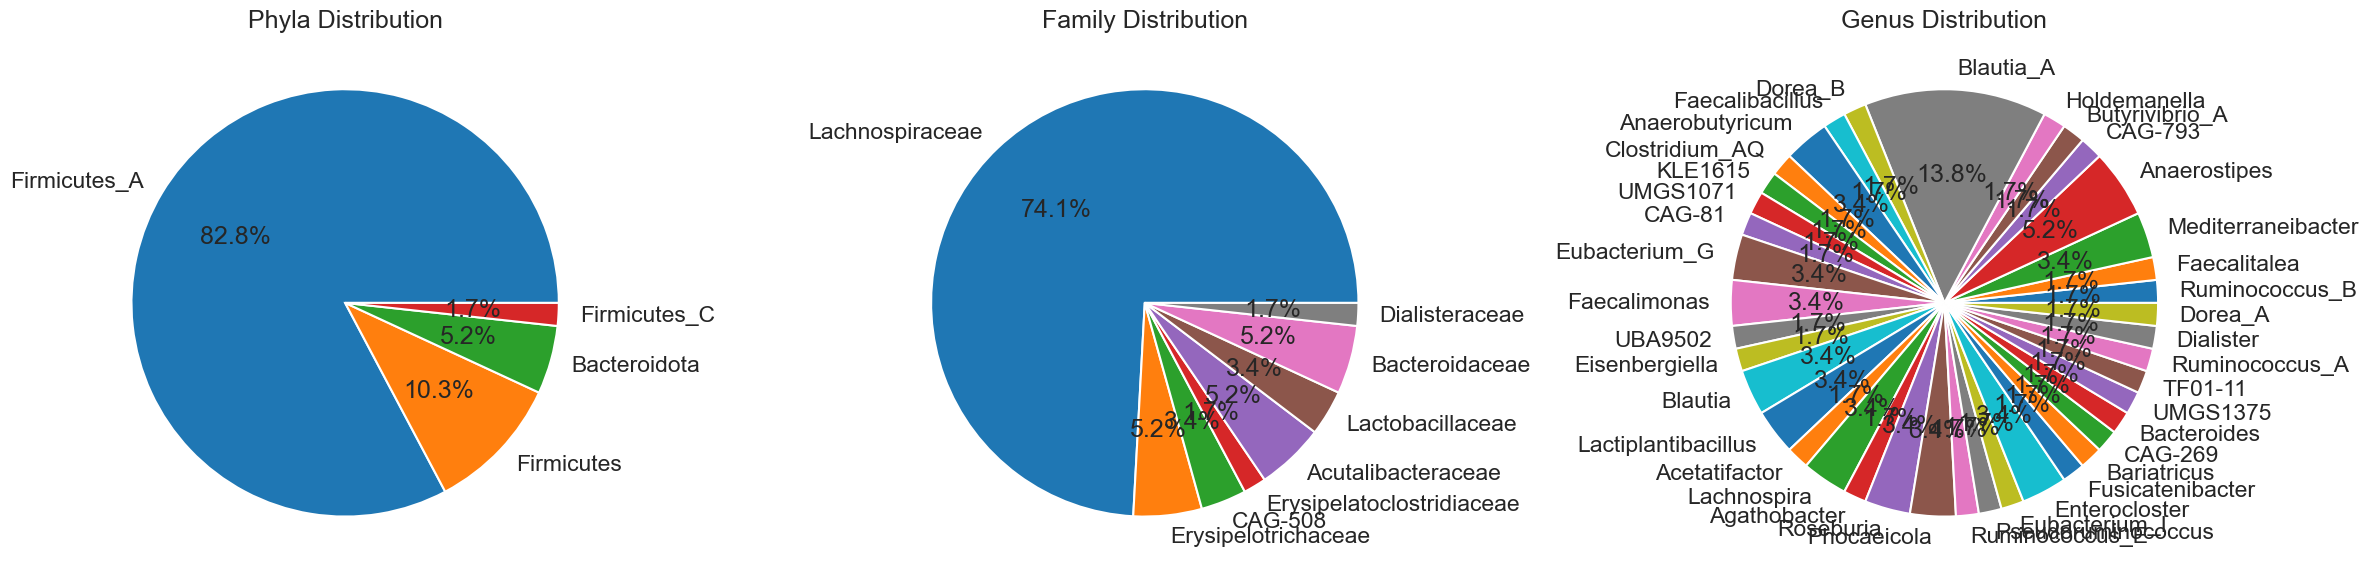

Peptidoglycan binding-like: 0.00014838996883810655%
Endopeptidase, NLPC/P60 domain: 0.9909482119008755%
SH3-like domain, bacterial-type: 0.6083988722362368%
Protein of unknown function DUF1058: 0.00014838996883810655%


C:\Users\odesa\AppData\Local\Temp\ipykernel_16988\2510369531.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  domain_plot = sns.barplot(x=domain_labels, y=domain_percentages, palette="Blues_d", edgecolor='black', linewidth=2)
C:\Users\odesa\AppData\Local\Temp\ipykernel_16988\2510369531.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  secretion_plot = sns.barplot(x=secretion_labels, y=secretion_percentages, palette="Greens_d", edgecolor='black', linewidth=2)


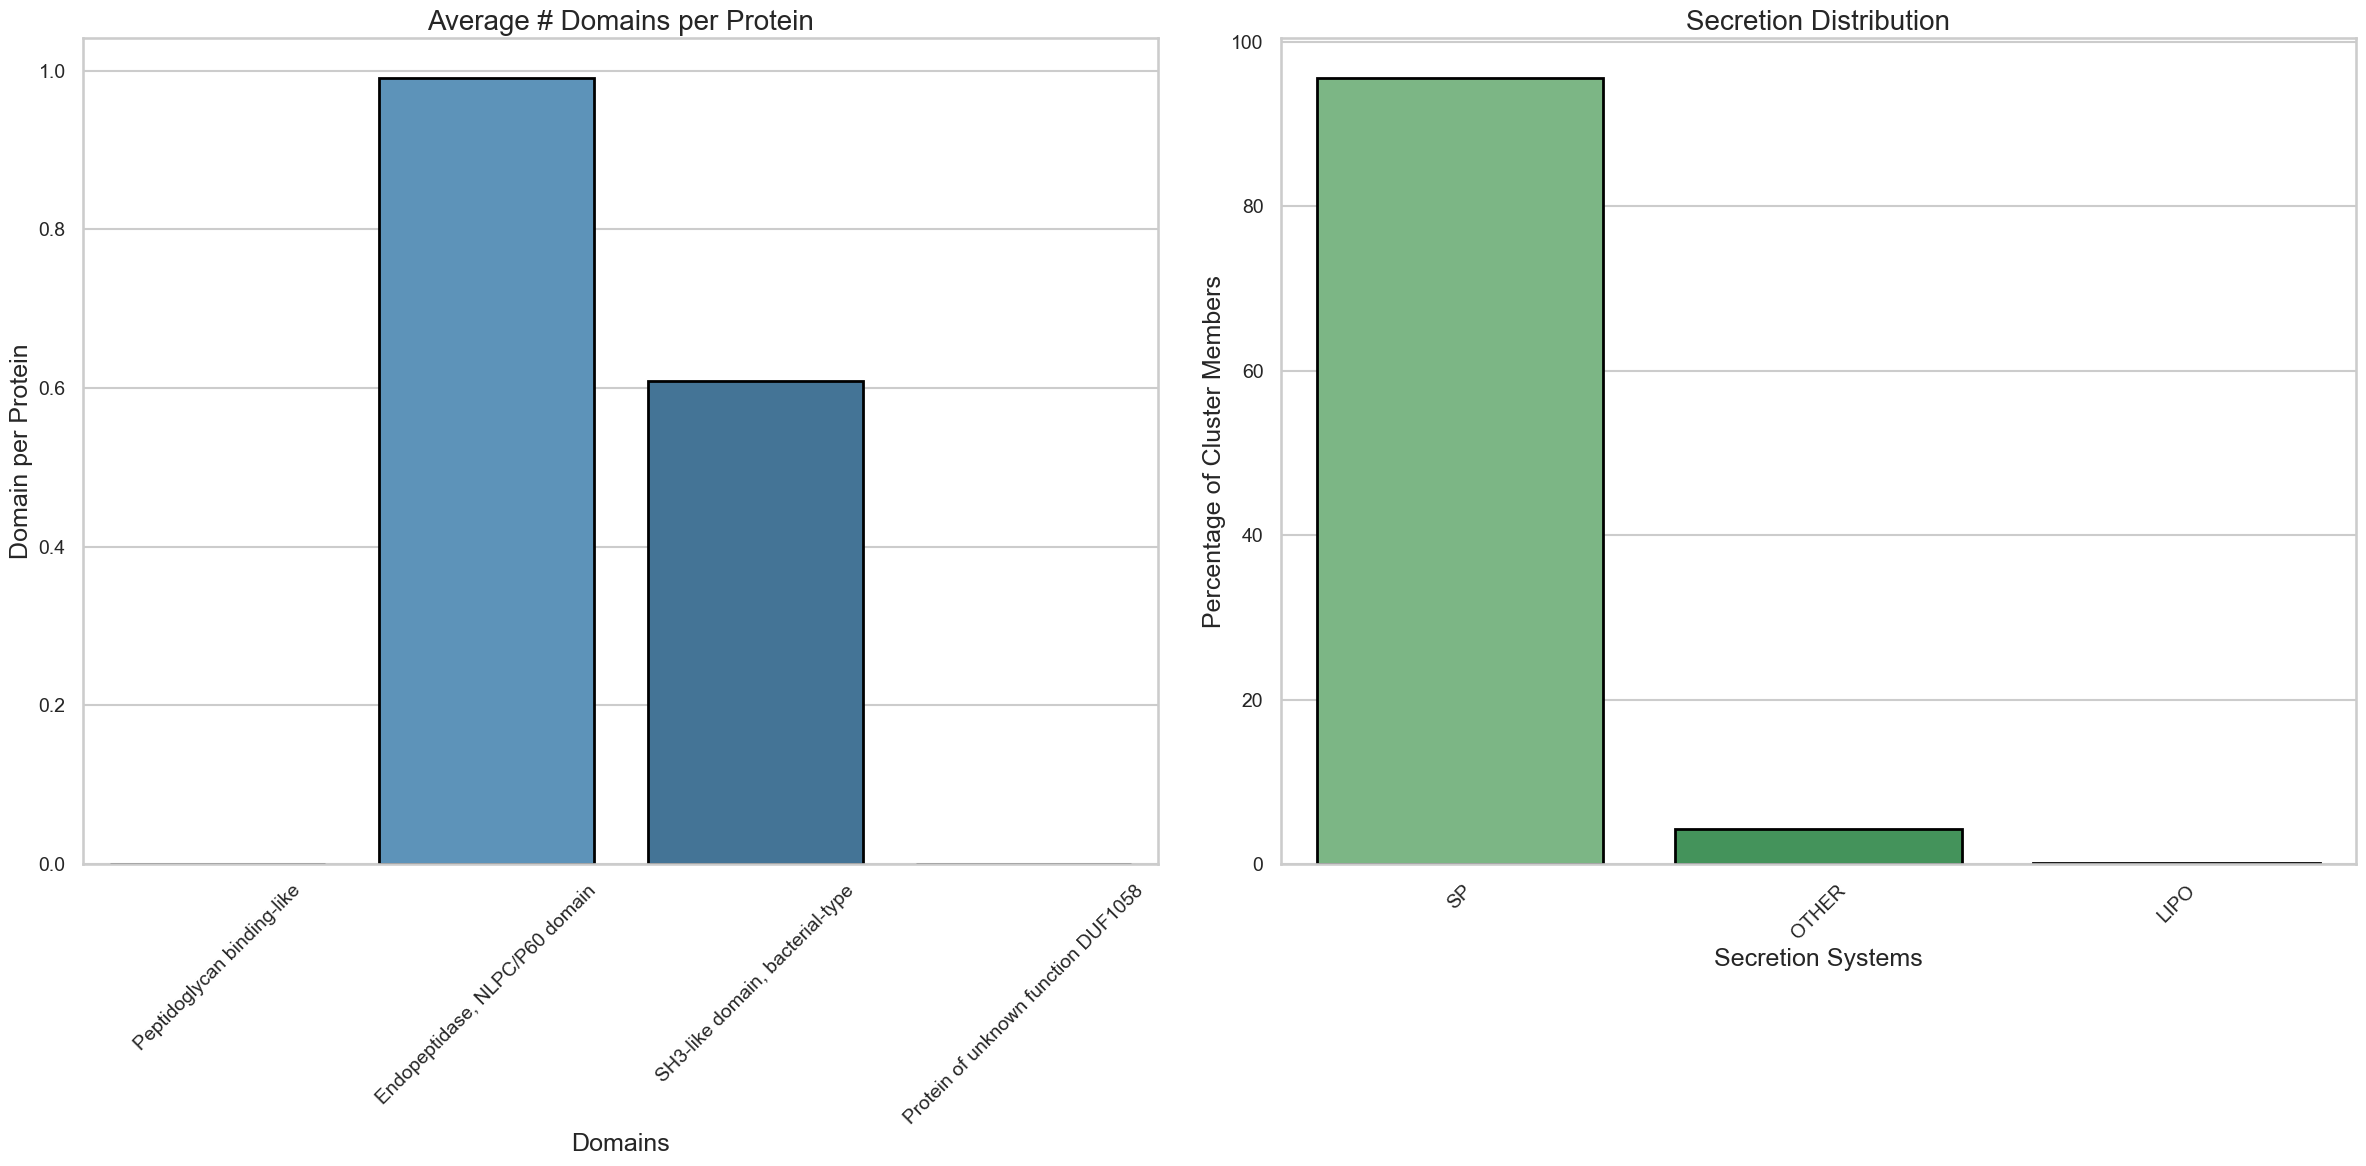

(None, None)


In [119]:
print(describe_cluster('A0A348AMN4', 'E:\\blastp_hits\\dl_endo_info.tsv', 'E:\\blastp_hits\\dl_endo_cluster_map.tsv'))

**The domain infographics look good but might not be showing the best information. For example, how many proteins dont have the domain at all? How many have 2 copies of the domain?**

In [13]:
# dl_and_sec.to_csv('dl_and_sec.tsv', sep='\t', index=False)

In [16]:
# Group by the foldseek cluster ID
grouped_data = dl_and_sec.groupby('dl_endopeptidase-foldseek_cluster')

# Initialize a list to hold the statistics for each cluster
cluster_stats = []

# Iterate over each group to calculate statistics
for cluster_id, group in grouped_data:
    total_proteins = group.shape[0]  # Total proteins in the cluster
    secreted_proteins = group[group['Prediction'] == 'SP'].shape[0]  # Proteins predicted as secreted
    percentage_secreted = (secreted_proteins / total_proteins) * 100  # Calculate the percentage
    
    # Append the statistics for this cluster to the list
    cluster_stats.append({
        'Foldseek Cluster ID': cluster_id,
        'Total Proteins': total_proteins,
        'Secreted Proteins': secreted_proteins,
        'Percentage Secreted': percentage_secreted
    })

# Convert the list of statistics into a DataFrame for better visualization
stats_df = pd.DataFrame(cluster_stats)

# Display the statistics DataFrame
stats_df.head()

,Foldseek Cluster ID,Total Proteins,Secreted Proteins,Percentage Secreted
0,A0A077MGS3,4,2,50.0
1,A0A078MK14,3,0,0.0
2,A0A0A2TFV7,3,3,100.0
3,A0A0B0HUJ2,5,0,0.0
4,A0A0D0RVH7,7,7,100.0
